# FarmOG Station - Model Evaluation
## Confusion Matrix & Performance Metrics for ResNet50V2

This notebook generates detailed evaluation metrics including confusion matrix, precision, recall, and F1-scores.

## Load Model & Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Load model
model = tf.keras.models.load_model('models/farmog_resnet50v2_classifier.h5')
with open('models/class_names.json') as f:
    class_names = json.load(f)

print('✅ Model loaded')

✅ Model loaded


## Load Validation Data

In [2]:
# Load validation data
valid_dir = Path('../data/raw/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid')
tomato_classes = [class_names[str(i)] for i in range(len(class_names))]

valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=tomato_classes,
    shuffle=False
)

print(f'Validation samples: {valid_gen.samples}')

Found 4585 images belonging to 10 classes.
Validation samples: 4585


## Generate Predictions

In [3]:
# Get predictions
print('Generating predictions...')
y_pred_probs = model.predict(valid_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = valid_gen.classes

print('✅ Predictions complete')

Generating predictions...
144/144 ━━━━━━━━━━━━━━━━━━━━ 74s 506ms/step
✅ Predictions complete


## Confusion Matrix Visualization

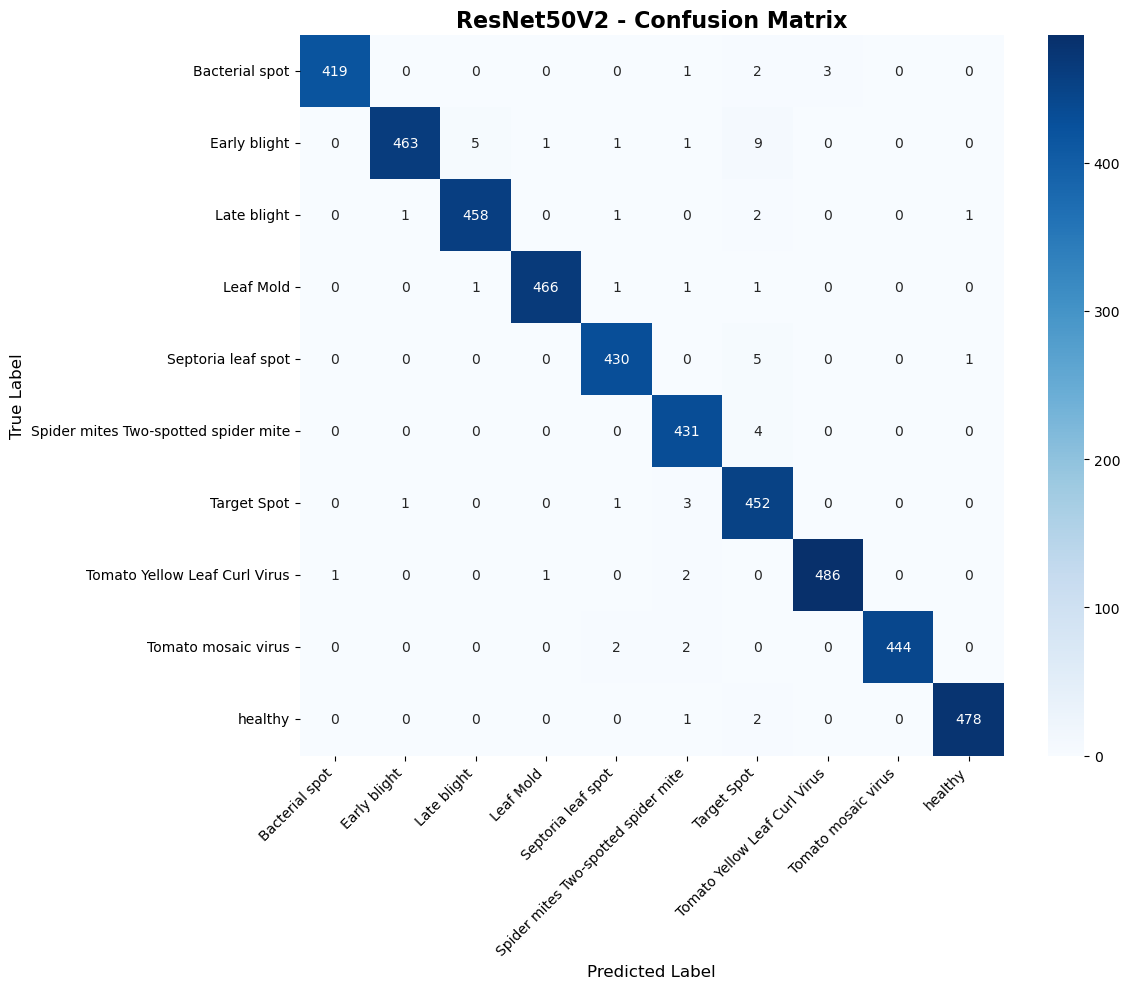

✅ Confusion matrix saved


In [4]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[c.replace('Tomato___', '').replace('_', ' ') for c in tomato_classes],
            yticklabels=[c.replace('Tomato___', '').replace('_', ' ') for c in tomato_classes])
plt.title('ResNet50V2 - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('docs/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print('✅ Confusion matrix saved')

## Classification Report

In [5]:
# Classification Report
report = classification_report(y_true, y_pred, 
                               target_names=[c.replace('Tomato___', '').replace('_', ' ') for c in tomato_classes],
                               output_dict=True)

print('='*60)
print('CLASSIFICATION REPORT')
print('='*60)
print(classification_report(y_true, y_pred, 
                           target_names=[c.replace('Tomato___', '').replace('_', ' ') for c in tomato_classes]))

CLASSIFICATION REPORT
                                      precision    recall  f1-score   support

                      Bacterial spot       1.00      0.99      0.99       425
                        Early blight       1.00      0.96      0.98       480
                         Late blight       0.99      0.99      0.99       463
                           Leaf Mold       1.00      0.99      0.99       470
                  Septoria leaf spot       0.99      0.99      0.99       436
Spider mites Two-spotted spider mite       0.98      0.99      0.98       435
                         Target Spot       0.95      0.99      0.97       457
       Tomato Yellow Leaf Curl Virus       0.99      0.99      0.99       490
                 Tomato mosaic virus       1.00      0.99      1.00       448
                             healthy       1.00      0.99      0.99       481

                            accuracy                           0.99      4585
                           macro avg    

## Per-Class Metrics Visualization

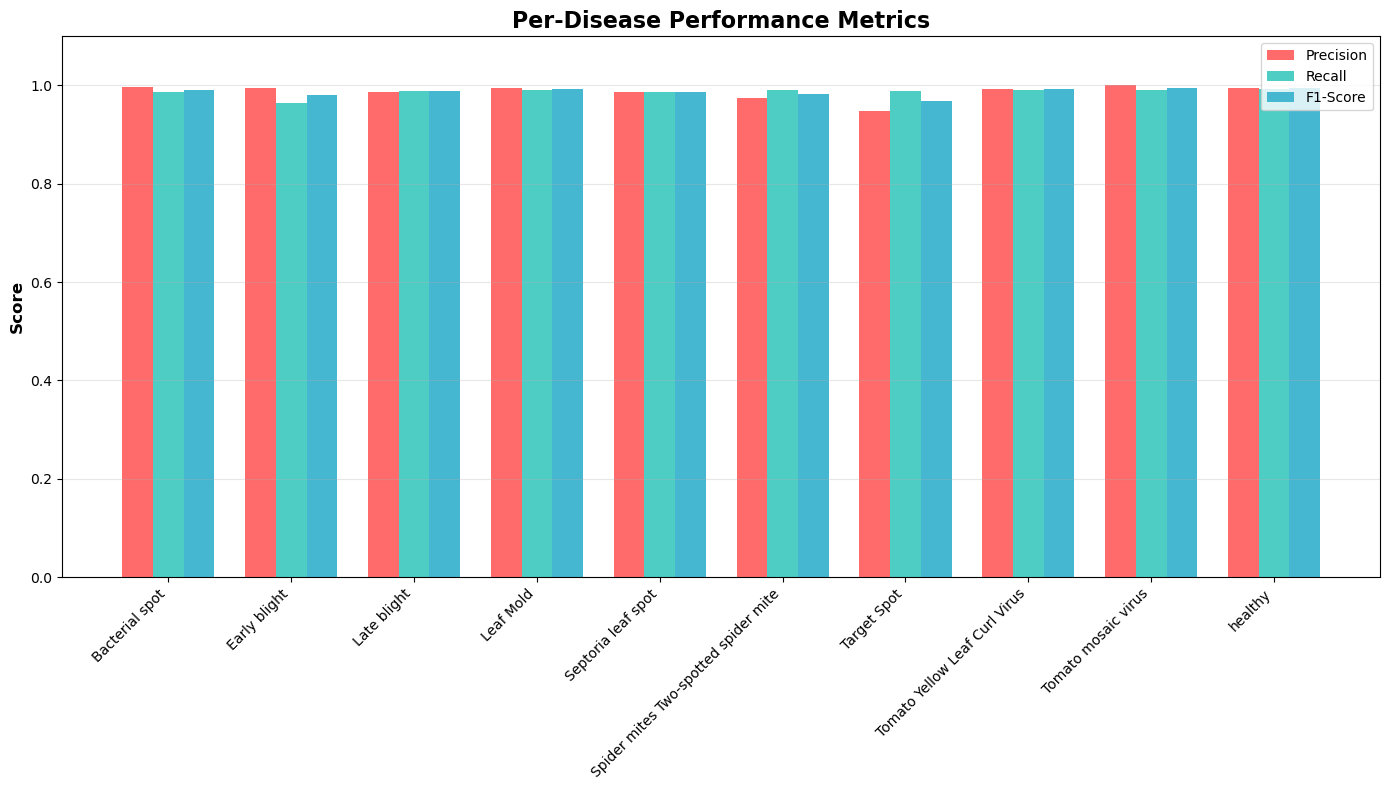

✅ Per-disease metrics saved


In [6]:
# Per-class metrics visualization
metrics_data = []
for disease in tomato_classes:
    display_name = disease.replace('Tomato___', '').replace('_', ' ')
    metrics_data.append({
        'Disease': display_name,
        'Precision': report[display_name]['precision'],
        'Recall': report[display_name]['recall'],
        'F1-Score': report[display_name]['f1-score']
    })

import pandas as pd
df_metrics = pd.DataFrame(metrics_data)

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(df_metrics))
width = 0.25

ax.bar(x - width, df_metrics['Precision'], width, label='Precision', color='#FF6B6B')
ax.bar(x, df_metrics['Recall'], width, label='Recall', color='#4ECDC4')
ax.bar(x + width, df_metrics['F1-Score'], width, label='F1-Score', color='#45B7D1')

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Disease Performance Metrics', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_metrics['Disease'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('docs/per_disease_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print('✅ Per-disease metrics saved')

## Overall Performance Summary

In [7]:
# Overall metrics
accuracy = np.mean(y_pred == y_true)
macro_f1 = report['macro avg']['f1-score']
weighted_f1 = report['weighted avg']['f1-score']

print('='*60)
print('OVERALL PERFORMANCE')
print('='*60)
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Macro F1-Score: {macro_f1:.4f}')
print(f'Weighted F1-Score: {weighted_f1:.4f}')
print(f'Total samples: {len(y_true)}')
print(f'Correctly classified: {np.sum(y_pred == y_true)}')
print(f'Misclassified: {np.sum(y_pred != y_true)}')

OVERALL PERFORMANCE
Accuracy: 98.74%
Macro F1-Score: 0.9874
Weighted F1-Score: 0.9874
Total samples: 4585
Correctly classified: 4527
Misclassified: 58


## Save Evaluation Report

In [8]:
# Save evaluation report
eval_report = {
    'model': 'ResNet50V2',
    'accuracy': float(accuracy),
    'macro_f1': float(macro_f1),
    'weighted_f1': float(weighted_f1),
    'total_samples': int(len(y_true)),
    'correct': int(np.sum(y_pred == y_true)),
    'incorrect': int(np.sum(y_pred != y_true)),
    'per_class_metrics': metrics_data
}

with open('models/evaluation_report.json', 'w') as f:
    json.dump(eval_report, f, indent=2)

print('✅ Evaluation report saved to models/evaluation_report.json')

✅ Evaluation report saved to models/evaluation_report.json
